In [323]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
import glob
import sys

Leidingtrace_WGS84.shp
Rioleringsdeelgebied_WGS84.shp
Rioolgemaal_WGS84.shp
RWZI_WGS84.shp
Zuiveringsregio_WGS84.shp


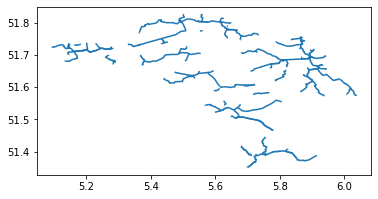

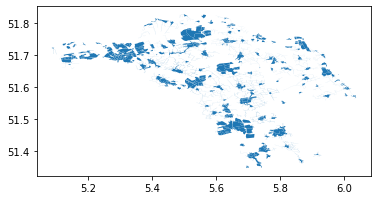

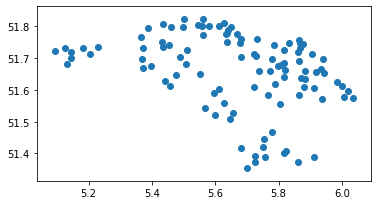

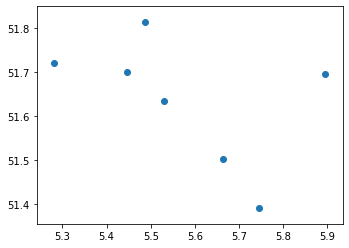

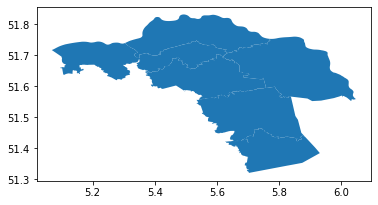

In [4]:
shape_path = "C:/Users/20175862/Documents/GitHub/jbg060/data/waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp_WGS84_2/"

for filename in os.listdir(shape_path):
    type = ".shp"
    Allsuffix=os.path.splitext(filename)
    file,suffix=Allsuffix
    if suffix==str(type):
        print(filename)
        gpd.GeoDataFrame.from_file(shape_path + filename).plot()

In [330]:
gdf = gpd.read_file("C:/Users/20175862/Documents/GitHub/jbg060/data/waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp_WGS84_2/Rioleringsdeelgebied_WGS84.shp")

pred_path = 'C:/Users/20175862/Documents/GitHub/jbg060/data/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_grid_prediction/knmi.harmonie_2018-01-01_2019-08-29/'

deelgebieden = pd.read_excel("C:/Users/20175862/Documents/GitHub/jbg060/data/waterschap-aa-en-maas_sewage_2019/sewer_model/20180717_dump riodat rioleringsdeelgebieden_DB.xlsx", skiprows = 9)


In [331]:
def cell_index(x, y, reduced = False):
    x_space = np.linspace(start = -0.0185, stop = -0.0185 + 300*0.037, num = 301)
    y_space = np.linspace(start = 48.9885, stop = 48.9885 + 300*0.023, num = 301)

    x_out = np.where(x >= x_space)[0][-1]
    y_out = 300 - np.where(y <= y_space)[0][0]

    if reduced:
        x_out = x_out - 91
        y_out = y_out - 101

    return x_out, y_out


def shapefile_preprocessing():

    list_pumps = list(deelgebieden['Naam kern'].unique())[0:6]
    list_pumps.append('Haarsteeg')

    deelgebieden = deelgebieden[['Volgnr', 'Code', 'Naam kern']]

    polygon_df = pd.merge(deelgebieden, gdf, left_on = 'Volgnr', right_on = 'RGDID')
    polygon_df = polygon_df[polygon_df['Naam kern'].isin(list_pumps)]

    bokhoven_polygons = polygon_df[polygon_df['Naam kern'] == 'Bokhoven']
    engelerschans_polygons = polygon_df[polygon_df['Naam kern'] == 'Engelen']
    helftheuvelweg_polygons = polygon_df[polygon_df['Naam kern'] == 'Hertogenbosch (Helftheuvelweg)']
    maaspoort_polygons = polygon_df[polygon_df['Naam kern'] == 'Hertogenbosch (Maaspoort)']
    oude_engelseweg_polygons = polygon_df[polygon_df['Naam kern'] == 'Hertogenbosch (Oude Engelenseweg)']
    rompert_polygons = polygon_df[polygon_df['Naam kern'] == 'Hertogenbosch (Rompert)']
    haarsteeg_polygons = polygon_df[polygon_df['Naam kern'] == 'Haarsteeg']
    
    return [bokhoven_polygons, engelerschans_polygons, helftheuvelweg_polygons, maaspoort_polygons, oude_engelseweg_polygons, rompert_polygons, haarsteeg_polygons]


def pred_per_pump(file_name):
    grid = np.loadtxt(file_name, skiprows = 7)
    
    dataframes = shapefile_preprocessing()
    predictions = []

    for df in dataframes:
        list_values = []
        for polygon in df['geometry']:
            for value in range(len(polygon.exterior.coords.xy[0])):
                x_coord = polygon.exterior.coords.xy[0][value]
                y_coord = polygon.exterior.coords.xy[1][value]
                indexes = cell_index(x_coord, y_coord)
        
            list_values.append(grid[indexes[0]][indexes[1]])
    
        prediction = sum(list_values)/len(list_values)
        predictions.append(prediction)
    
    return predictions


def predictions_preprocessing():

    timestamp_list = []
    for filename in os.listdir(pred_path):
        type = ".asc"
        suffixtotal = os.path.splitext(filename)
        file,suffix = suffixtotal
        if suffix == str(type):
            timestamp_list.append(filename.split('_')[3])
    
    return timestamp_list


def prediction_whole_df(pred_path):
    bokhoven_pred = []
    engelerschans_pred = []
    helftheuvelweg_pred = []
    maaspoort_pred = []
    oude_engelseweg_pred = []
    rompert_pred = []
    haarsteeg_pred = []
    
    for filename in os.listdir(pred_path):
        type = ".asc"
        suffixtotal = os.path.splitext(filename)
        file,suffix = suffixtotal
        if suffix == str(type):
            preds = pred_per_pump(pred_path+filename)
        bokhoven_pred.append(preds[0])
        engelerschans_pred.append(preds[1])
        helftheuvelweg_pred.append(preds[2])
        maaspoort_pred.append(preds[3])
        oude_engelseweg_pred.append(preds[4])
        rompert_pred.append(preds[5])
        haarsteeg_pred.append(preds[6])
    
    return bokhoven_pred, engelerschans_pred, helftheuvelweg_pred, maaspoort_pred, oude_engelseweg_pred, rompert_pred, haarsteeg_pred



In [272]:
all_df = prediction_whole_df(pred_path)


In [321]:
bokhoven_pred = pd.DataFrame()
bokhoven_pred['dates'] = timestamps
bokhoven_pred['rainfall prediction'] = all_df[0][1:]
bokhoven_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/bokhoven rainfall prediction')

engelerschans_pred = pd.DataFrame()
engelerschans_pred['dates'] = timestamps
engelerschans_pred['rainfall prediction'] = all_df[1][1:]
engelerschans_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/engelerschans rainfall prediction')

helftheuvelweg_pred = pd.DataFrame()
helftheuvelweg_pred['dates'] = timestamps
helftheuvelweg_pred['rainfall prediction'] = all_df[2][1:]
helftheuvelweg_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/helftheuvelweg rainfall prediction')

maaspoort_pred = pd.DataFrame()
maaspoort_pred['dates'] = timestamps
maaspoort_pred['rainfall prediction'] = all_df[3][1:]
maaspoort_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/maaspoort rainfall prediction')

oude_engelseweg_pred = pd.DataFrame()
oude_engelseweg_pred['dates'] = timestamps
oude_engelseweg_pred['rainfall prediction'] = all_df[4][1:]
oude_engelseweg_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/oude_engelseweg rainfall prediction')

rompert_pred = pd.DataFrame()
rompert_pred['dates'] = timestamps
rompert_pred['rainfall prediction'] = all_df[5][1:]
rompert_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/rompert rainfall prediction')

haarsteeg_pred = pd.DataFrame()
haarsteeg_pred['dates'] = timestamps
haarsteeg_pred['rainfall prediction'] = all_df[6][1:]
haarsteeg_pred.to_csv('C:/Users/20175862/Documents/Data Challenge 3/rainfall predictions/haarsteeg rainfall prediction')



In [306]:
timestamps = predictions_preprocessing()

list_pumps = list(deelgebieden['Naam kern'].unique())[0:6]
list_pumps = list_pumps.append('Haarsteeg')


for i in range(len(timestamps)):
    timestamps[i] = datetime.datetime.strptime(timestamps[i], '%Y-%m-%dT%Hh%Mm%Ss')
    #timestamps[i].strftime('%d/%m/%Y  %H:%M:%S')
timestamps

num=0
for filename in os.listdir(pred_path):
        type = ".asc"
        suffixtotal = os.path.splitext(filename)
        file,suffix = suffixtotal
        if suffix == str(type):
            num+=1


In [86]:
coordinates_y = np.zeros((300,300))
x_coord_ll = -0.0185
y_coord_ll = 48.988500000000

dx = 0.037
dy = 0.023
for i in range(len(coordinates_y)):
    for j in range(len(coordinates_y[0])):
        coordinates_y[i][j] = y_coord_ll + (i*dy)
        
#coordinates_y = print(coordinates_y)
coordinates_y

array([[48.9885, 48.9885, 48.9885, ..., 48.9885, 48.9885, 48.9885],
       [49.0115, 49.0115, 49.0115, ..., 49.0115, 49.0115, 49.0115],
       [49.0345, 49.0345, 49.0345, ..., 49.0345, 49.0345, 49.0345],
       ...,
       [55.8195, 55.8195, 55.8195, ..., 55.8195, 55.8195, 55.8195],
       [55.8425, 55.8425, 55.8425, ..., 55.8425, 55.8425, 55.8425],
       [55.8655, 55.8655, 55.8655, ..., 55.8655, 55.8655, 55.8655]])

In [85]:
coordinates_x = np.zeros((300,300))
x_coord_ll = -0.0185
y_coord_ll = 48.988500000000

dx = 0.037
dy = 0.023
for i in range(len(coordinates_x)):
    for j in range(len(coordinates_x[0])):
        coordinates_x[i][j] = x_coord_ll + (j*dx)
        
        
#coordinates_x = print(coordinates_x)
coordinates_x

array([[-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445],
       [-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445],
       [-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445],
       ...,
       [-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445],
       [-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445],
       [-0.0185,  0.0185,  0.0555, ..., 10.9705, 11.0075, 11.0445]])